# 🌆 Urban Heat Island Detection & Cooling Infrastructure Mapping – Pune City

**Duration:** May 2025 – Present  
**Tech Stack:** Python, Google Colab, Landsat 9 TIRS, GeoJSON, OSM Overpass API  
**Libraries:** `geopandas`, `osmnx`, `rasterio`, `rasterstats`, `scikit-learn`, `matplotlib`, `numpy`

This project identifies Urban Heat Island (UHI) zones in Pune by integrating satellite-derived land surface temperature with vector data of green and blue spaces, offering insights into urban cooling strategies.

# Phase 1: Extract Green and Water Bodies using Overpass API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install leafmap numpy matplotlib geopandas rasterio folium shapely geemap osmnx streamlit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.6/567.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 

In [2]:
!pip install --upgrade osmnx

<Axes: >

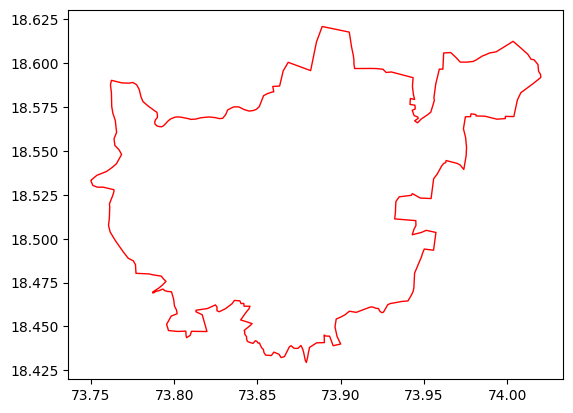

In [3]:
# Step 2: Load Pune AOI from GeoJSON
import geopandas as gpd

# Load Pune boundary
aoi = gpd.read_file('/content/drive/MyDrive/UHI/pune_boundary.geojson')

# Ensure it's in WGS84
aoi = aoi.to_crs(epsg=4326)

# Plot to check
aoi.plot(edgecolor='red', facecolor='none')

In [4]:
import geopandas as gpd
import pandas as pd
import osmnx as ox

# Load AOI GeoJSON
aoi = gpd.read_file("/content/drive/MyDrive/UHI/pune_boundary.geojson")
aoi = aoi.to_crs(epsg=4326)
aoi_polygon = aoi.geometry.iloc[0]

# Define rich tag filters
green_tags = {
    'leisure': ['park', 'garden', 'recreation_ground'],
    'landuse': ['grass', 'recreation_ground', 'forest'],
    'natural': ['wood', 'scrub', 'grassland']
}

water_tags = {
    'natural': ['water'],
    'water': True,
    'waterway': True
}

# ✅ Use features_from_polygon (reliable version)
green_gdf = ox.features_from_polygon(aoi_polygon, tags=green_tags)
water_gdf = ox.features_from_polygon(aoi_polygon, tags=water_tags)

# Drop null geometries
green_gdf = green_gdf[green_gdf.geometry.notnull()]
water_gdf = water_gdf[water_gdf.geometry.notnull()]

# Add label column
green_gdf["type"] = "green_space"
water_gdf["type"] = "water_body"

# Combine and clip
combined = gpd.GeoDataFrame(pd.concat([green_gdf, water_gdf], ignore_index=True), crs="EPSG:4326")
combined_clipped = gpd.clip(combined, aoi)

# Export with full tags and attributes
combined_clipped.to_file("/content/drive/MyDrive/UHI/pune_green_water_fulltags.geojson", driver="GeoJSON")

## Retrieve and Visualize Urban LST


In [33]:
import geemap
import ee
import geopandas as gpd

ee.Authenticate()
# Replace 'your-google-cloud-project-id' with your actual project ID
try:
    ee.Initialize(project='ee-prachisarode95')
except ee.EEException as e:
    print(f"Earth Engine initialization failed: {e}")

# # Convert aoi to EE Feature
roi = geemap.geopandas_to_ee(aoi)

# Load Landsat 9 LST ImageCollection
collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')\
    .filterBounds(roi)\
    .filterDate('2025-03-01', '2025-05-31')\
    .filter(ee.Filter.lt('CLOUD_COVER', 5))

# Take median image
image = collection.median()

# Convert DN to LST (Kelvin to Celsius)
mult = 0.00341802
add = 149.0

# Calculate LST and mask invalid values
lst = image.select('ST_B10')\
    .multiply(mult)\
    .add(add)\
    .subtract(273.15)\
    .rename('LST')

# Mask LST values <= 0 (often invalid) and NaN
lst_masked = lst.updateMask(lst.gt(0))  # masks values ≤ 0

# Clip to ROI
lst_clipped = lst_masked.clip(roi)

# Export and Visualize only valid LST pixels on the map
geemap.ee_export_image(lst_clipped, filename='/content/drive/MyDrive/UHI/LST_cleaned.tif', region=roi.geometry(), scale=30, file_per_band=False)
Map.addLayer(lst_clipped, {"min": 20, "max": 45, "palette": ['blue', 'limegreen', 'yellow', 'red']}, "LST Masked")
Map

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/UHI/LST_cleaned.tif


Map(bottom=469674.0, center=[18.52186929732393, 73.86661902133402], controls=(WidgetControl(options=['position…

# Phase 2: Load and Mask Land Surface Temperature Raster

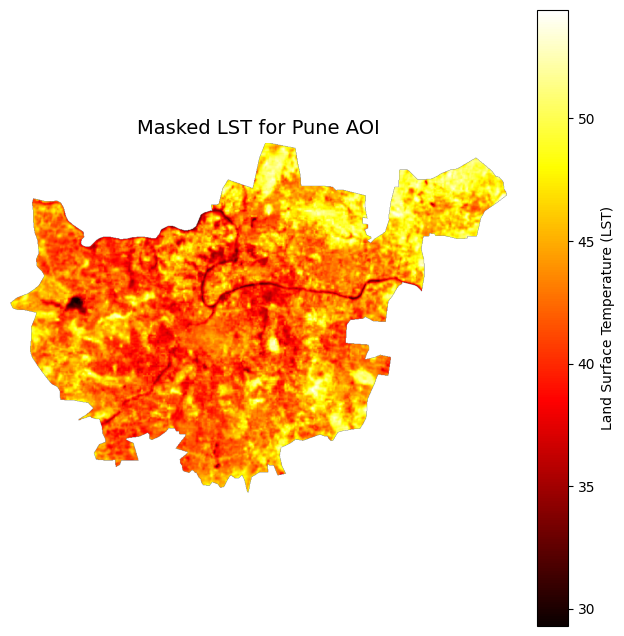

In [35]:
import rasterio
from rasterio.mask import mask
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from shapely.geometry import mapping

# Read the raster (LST) and clip it using AOI bounds
with rasterio.open("/content/drive/MyDrive/UHI/LST_cleaned.tif") as lst_src:
    aoi_bounds = [mapping(geom) for geom in aoi.geometry]  # Fixing the geometry extraction
    masked_lst, masked_transform = mask(lst_src, aoi_bounds, crop=True)
    masked_lst = masked_lst[0]

# Replace 0 or invalid values with np.nan
masked_lst = np.where(masked_lst <= 0, np.nan, masked_lst)

# Mask NaN values for a cleaner plot
masked_array = ma.masked_invalid(masked_lst)

# Plotting
plt.figure(figsize=(8, 8))
plt.imshow(masked_array, cmap='hot')
plt.title("Masked LST for Pune AOI", fontsize=14)
plt.axis('off')

cbar = plt.colorbar(label="Land Surface Temperature (LST)")
cbar.ax.tick_params(labelsize=10)

plt.savefig("/content/drive/MyDrive/UHI/masked_LST_cleaned.png", bbox_inches='tight', dpi=300, transparent=True)
plt.show()


# Phase 3: Zonal Statistics – Mean LST for Cooling Features

In [10]:
!pip install rasterstats --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.4 MB/s eta 0:00:00


In [36]:
# Phase 3: Zonal Statistics – Mean LST for Cooling Features
from rasterstats import zonal_stats
import geopandas as gpd

# Ensure geometries are valid and in same CRS as raster
combined_clipped = combined_clipped.to_crs(lst_src.crs)

# Run zonal statistics using masked LST and transform
zs = zonal_stats(
    vectors=combined_clipped,
    raster=masked_lst,
    affine=masked_transform,
    stats=['mean'],
    nodata=lst_src.nodata,
    geojson_out=False  # Only return stats, not geometries
)

# Attach mean LST to GeoDataFrame
combined_clipped['mean_LST'] = [stat['mean'] for stat in zs]

# Remove features without valid LST values
combined_clipped = combined_clipped.dropna(subset=['mean_LST'])

# Save to GeoJSON for reuse
combined_clipped.to_file("/content/drive/MyDrive/UHI/pune_cooling_with_LST.geojson", driver="GeoJSON")

# ---- Visualization ----
# Convert GeoDataFrame to Earth Engine object
cooling_combined_ee = geemap.geopandas_to_ee(combined_clipped)

# Add layers to the map
Map.addLayer(cooling_combined_ee, {'color': 'aqua'}, "Cooling Infrastructure (Polygons)")
Map.addLayer(cooling_combined_ee, {'color': 'orange'}, "Mean LST for Cooling Infra")

# Display final map
Map

Map(bottom=469674.0, center=[18.52186929732393, 73.86661902133402], controls=(WidgetControl(options=['position…

# Phase 4: Urban Heat Island Classification with KMeans

Unique cluster labels found (excluding NaNs): [0. 1. 2. 3.]


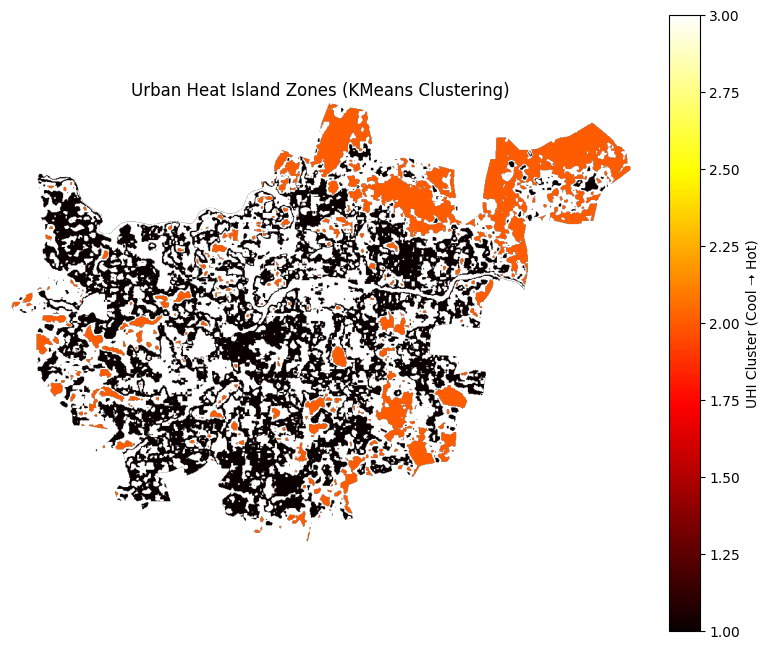

Clustered UHI raster saved to: /content/drive/MyDrive/UHI/kmeans_uhi_clusters.tif


In [39]:
# Phase 4: Urban Heat Island Classification with KMeans

# 🔧 Required Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# 🔄 Step 1: Prepare the masked LST pixel values for clustering
pixels = masked_lst.flatten()
pixels = pixels[~np.isnan(pixels)].reshape(-1, 1)  # Remove NaNs and reshape for scaler

# 🧪 Step 2: Normalize the pixel values
scaler = StandardScaler()
pixels_scaled = scaler.fit_transform(pixels)

# 🧠 Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(pixels_scaled)

# 🧩 Step 4: Rebuild labels array with original shape, filling with NaNs where masked
labels = np.full(masked_lst.shape, np.nan)
flat_idx = ~np.isnan(masked_lst)
labels[flat_idx] = kmeans.labels_

# 🧹 Step 5: Optional - Mask cluster 0 if it corresponds to background or low LST values
print("Unique cluster labels found (excluding NaNs):", np.unique(labels[~np.isnan(labels)]))

labels_masked = np.where(labels == 0, np.nan, labels)  # Mask cluster 0 if needed

# 🎨 Step 6: Plot UHI clusters with Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(labels_masked, cmap='hot')
plt.title("Urban Heat Island Zones (KMeans Clustering)")
plt.colorbar(label='UHI Cluster (Cool ➝ Hot)')
plt.axis('off')
plt.savefig("/content/drive/MyDrive/UHI/phase4_kmeans_clusters.png", dpi=300)
plt.show()

# 💾 Step 7: Save clustered raster to GeoTIFF with appropriate metadata
cluster_raster_path = "/content/drive/MyDrive/UHI/kmeans_uhi_clusters.tif"

# Update metadata for output raster
out_meta = lst_src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "dtype": "float32",
    "count": 1,
    "height": labels_masked.shape[0],
    "width": labels_masked.shape[1],
    "transform": masked_transform,
    "nodata": np.nan
})

# Save the clustered labels as float32 GeoTIFF
with rasterio.open(cluster_raster_path, "w", **out_meta) as dest:
    dest.write(labels_masked.astype('float32'), 1)

print(f"Clustered UHI raster saved to: {cluster_raster_path}")

In [45]:
import geemap
import rasterio
from branca.colormap import linear

# Initialize geemap Map centered on Pune
m = geemap.Map(center=[18.52, 73.85], zoom=11)

# Load your saved cluster GeoTIFF
with rasterio.open(cluster_raster_path) as src:
    cluster_craster_path = cluster_raster_path
    cluster_array = src.read(1)
    cluster_transform = src.transform
    cluster_crs = src.crs

# Load and add raster layer
cluster_raster_path = "/content/drive/MyDrive/UHI/kmeans_uhi_clusters.tif"
m.add_raster(cluster_raster_path, colormap='hot', layer_name="UHI KMeans Clusters", opacity=0.7)

# Define cluster names based on intensity (example mapping)
cluster_names = {
    'Cool Zone': '#fee08b',  # light yellow
    'Moderate Heat Zone': '#fdae61',  # orange
    'High Heat Zone': '#f46d43',  # dark orange
    'Extreme Heat Zone': '#d73027',  # red
}
# Add legend control to the map
m.add_legend(title="UHI Cluster Zones", labels=list(cluster_names.keys()), colors=list(cluster_names.values()))

# Display the map
m

Map(center=[18.52, 73.85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

---

## 🔍 Key Highlights

- Integrated remote sensing raster analysis with vector GIS data for urban spatial modeling

- Applied KMeans clustering for unsupervised classification of Urban Heat Island (UHI) zones using normalized Land Surface Temperature (LST)

- Extracted urban cooling infrastructure (green spaces, water bodies) from OpenStreetMap using Overpass API

- Visualized and exported classified UHI zones as GeoTIFF and interactive maps for portfolio and climate resilience planning

---

## 📁 Outputs

-`pune_green_water_fulltags.geojson` — Extracted urban cooling features (green spaces and water bodies)

-`pune_cooling_with_LST.geojson` — Cooling features enriched with zonal mean LST values

-`masked_LST_cleaned.png` — Visualization of masked LST raster showing study area temperature

-`phase4_kmeans_clusters.png` — Final Urban Heat Island zones classified via KMeans clustering

-`kmeans_uhi_clusters.tif` — GeoTIFF raster file of the classified UHI zones for further GIS analysis and visualization